## fluxo de busca de hiperparametros

1. Etapa Incial: `RandomizedSearchCV` Explorar região inicial de hiperparametros.

2. Refinamento: `RandomizedSearchCV` Explorar região promissora

3. Busca final: `BayesSearchCV`Refinamento inteligente aa região promissora

In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import time

# XGBoost
from xgboost import XGBClassifier
# sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin, clone

from scipy.stats import ttest_rel

#hiperparamentros search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical


# Importações locais
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from src.preprocess_utils_tic import preprocessador_titanic

## 1. Load Data & Pipeline

In [2]:
BASE = Path.cwd().parent

PP2 = joblib.load(BASE/'src'/'preprocess_Titanic_v1.2.joblib')['preprocessador']

DATA_DIR = BASE/"data"/"raw"
X_train = pd.read_csv(DATA_DIR/"X_train_raw.csv")
X_test  = pd.read_csv(DATA_DIR/"X_test_raw.csv")
y_train = pd.read_csv(DATA_DIR/"y_train_raw.csv").values.ravel()
y_test  = pd.read_csv(DATA_DIR/"y_test_raw.csv").values.ravel()

## 2. Load Data & Pipeline

In [6]:
# Baseline
model_base = XGBClassifier(objective='binary:logistic',eval_metric='logloss',random_state=42,n_jobs=-1)
pipe_base = pipe_models(model_base, PP2) #pipeBASELINE

pipe_base.fit(X_train, y_train)
y_probs0 = pipe_base.predict_proba(X_test)[:, 1]


# 2. Testar vários thresholds
thresholds = np.linspace(0.3, 0.7, 41)
best_threshold0 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs0 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold0 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold0:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

baseline_scores = cross_val_score(pipe_base, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Baseline: {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")
print(f"Average CV Accuracy: {np.mean(baseline_scores)*100:.2f}%") 

mtd_scoring='accuracy'

🎯 Melhor Threshold: 0.640
📈 Melhor Acurácia de Teste: 0.8022
Baseline: 0.8235 ± 0.0485
Average CV Accuracy: 82.35%


## 3.Buscas por hiperparamentros
### 3.1.Random Search (Exploratória)

In [8]:
param_dist_1 = {
    'model__n_estimators': randint(50, 1000),
    'model__max_depth': randint(2, 15),
    'model__min_child_weight': randint(1, 20),
    'model__gamma': uniform(0, 5),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__reg_alpha': uniform(0, 2),
    'model__reg_lambda': uniform(0.5, 3)
}


search_1 = RandomizedSearchCV(
    pipe_base, param_dist_1,
    n_iter=50, cv=10,
    scoring=mtd_scoring,
    random_state=42, n_jobs=-1, verbose=1
)

start = time.time()
search_1.fit(X_train, y_train)
end = time.time()

best_1 = search_1.best_estimator_


# 2. Testar vários thresholds
y_probs1 = best_1.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.3, 0.7, 41)
best_threshold1 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs1 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold1 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold1:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

#ACCURACY
scores1 = cross_val_score(best_1, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores1.mean():.4f} ± {scores1.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores1)*100:.2f}%")
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/50:.2f} segundos")
print("📌 Melhores Parâmetros:")
print(search_1.best_params_)
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))


Fitting 10 folds for each of 50 candidates, totalling 500 fits
🎯 Melhor Threshold: 0.630
📈 Melhor Acurácia de Teste: 0.8209
Optimized: 0.8411 ± 0.0558
Average CV Accuracy: 84.11%
Tempo total: 25.34 segundos
Tempo por iteração: 0.51 segundos
📌 Melhores Parâmetros:
{'model__colsample_bytree': 0.5230013210108764, 'model__gamma': 0.20364401159485068, 'model__learning_rate': 0.2666381752033022, 'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 253, 'model__reg_alpha': 0.03432220366350047, 'model__reg_lambda': 2.7900932690117326, 'model__subsample': 0.9034564885253897}

#Processo finalizado em: 15:08:29


### 3.2 Random Search Refinado

In [9]:
param_dist_2 = {
    'model__n_estimators': randint(200, 350),
    'model__max_depth': [4, 5, 6],
    'model__min_child_weight': [3, 4, 5, 6, 7],
    'model__gamma': uniform(0.0, 0.5),
    'model__learning_rate': uniform(0.15, 0.15),  # ~ 0.15–0.30
    'model__subsample': uniform(0.75, 0.25),
    'model__colsample_bytree': uniform(0.45, 0.15),
    'model__reg_alpha': uniform(0.0, 0.2),
    'model__reg_lambda': uniform(2.0, 1.5)
}


search_2 = RandomizedSearchCV(
    pipe_base, param_dist_2,
    n_iter=80, cv=10,
    scoring=mtd_scoring,
    random_state=42, n_jobs=-1, verbose=1

)
start = time.time()
search_2.fit(X_train, y_train)
end = time.time()

best_2 = search_2.best_estimator_
# 2. Testar vários thresholds
y_probs2 = best_2.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.3, 0.7, 41)
best_threshold2 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs2 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold2 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold2:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

#ACCURACY
scores2 = cross_val_score(best_2, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores2.mean():.4f} ± {scores2.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores2)*100:.2f}%")
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/80:.2f} segundos")
print("📌 Melhores Parâmetros:")
print(search_2.best_params_)
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))


Fitting 10 folds for each of 80 candidates, totalling 800 fits
🎯 Melhor Threshold: 0.520
📈 Melhor Acurácia de Teste: 0.8358
Optimized: 0.8491 ± 0.0494
Average CV Accuracy: 84.91%
Tempo total: 33.17 segundos
Tempo por iteração: 0.41 segundos
📌 Melhores Parâmetros:
{'model__colsample_bytree': 0.5524895278238188, 'model__gamma': 0.30499832889131046, 'model__learning_rate': 0.27497923676042463, 'model__max_depth': 6, 'model__min_child_weight': 3, 'model__n_estimators': 249, 'model__reg_alpha': 0.1325044568707964, 'model__reg_lambda': 2.4675666141341166, 'model__subsample': 0.8800170052944527}

#Processo finalizado em: 15:09:38


### 3.3 Bayesian Optimization (Optuna / skopt)

In [11]:
##  Definição do Espaço Bayesiano
param_dist_3 = {
    'model__n_estimators': Integer(220, 280),
    'model__max_depth': Integer(5, 7),
    'model__min_child_weight': Integer(2, 4),
    'model__gamma': Real(0.0, 0.4),
    'model__learning_rate': Real(0.2, 0.3),
    'model__subsample': Real(0.75, 0.95),
    'model__colsample_bytree': Real(0.45, 0.70),
    'model__reg_alpha': Real(0.0, 0.3),
    'model__reg_lambda': Real(1.5, 3.5)
}

#Configuração do BayesSearch
bayes_search = BayesSearchCV(
    estimator=pipe_base,
    search_spaces=param_dist_3,
    n_iter=40,
    cv=10,
    scoring=mtd_scoring,
    random_state=42,
    n_jobs=-1,
verbose=0)

start = time.time()
## Execução
print("🔍 Iniciando Bayesian Optimization...")
bayes_search.fit(X_train, y_train)
end = time.time()


best_3 = bayes_search.best_estimator_
# 2. Testar vários thresholds
y_probs3 = best_3.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.3, 0.7, 41)
best_threshold3 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs3 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold3 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold3:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

#ACCURACY
scores3 = cross_val_score(best_3, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores3.mean():.4f} ± {scores3.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores2)*100:.2f}%")
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/40:.2f} segundos")
print("📌 Melhores Parâmetros:")
print(bayes_search.best_params_)
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))

🔍 Iniciando Bayesian Optimization...
🎯 Melhor Threshold: 0.460
📈 Melhor Acurácia de Teste: 0.8209
Optimized: 0.8475 ± 0.0408
Average CV Accuracy: 84.91%
Tempo total: 67.28 segundos
Tempo por iteração: 1.68 segundos
📌 Melhores Parâmetros:
OrderedDict([('model__colsample_bytree', 0.4554157442805486), ('model__gamma', 0.24241179768387422), ('model__learning_rate', 0.26444508640179465), ('model__max_depth', 7), ('model__min_child_weight', 3), ('model__n_estimators', 239), ('model__reg_alpha', 0.2141711630760044), ('model__reg_lambda', 2.4646636843175624), ('model__subsample', 0.9198282243745902)])

#Processo finalizado em: 15:11:58


## 4. Comparação Estatística

In [14]:
# Calcula os scores de validação cruzada para cada modelo(roc_auc)
s1 = cross_val_score(best_1, X_train, y_train, cv=10,scoring='roc_auc')
s2 = cross_val_score(best_2, X_train, y_train, cv=10,scoring='roc_auc')
s3 = cross_val_score(best_3, X_train, y_train, cv=10,scoring='roc_auc')

# Calcula os scores de validação cruzada para cada modelo(acc)
s1_acc = cross_val_score(best_1, X_train, y_train, cv=10)
s2_acc= cross_val_score(best_2, X_train, y_train, cv=10)
s3_acc = cross_val_score(best_3, X_train, y_train, cv=10)

best_1.fit(X_train, y_train)
best_2.fit(X_train, y_train)
best_3.fit(X_train, y_train)

score1 = best_1.score(X_test, y_test)
score2 = best_2.score(X_test, y_test)
score3 = best_3.score(X_test, y_test)

y_prob1 = best_1.predict_proba(X_test)[:, 1]
y_prob2 = best_2.predict_proba(X_test)[:, 1]
y_prob3 = best_3.predict_proba(X_test)[:, 1]


# 1. Preparação dos Dados de Performance
models_list = [
    ('Modelo 1 (Random)', best_1, s1, s1_acc, y_prob1, best_threshold1),
    ('Modelo 2 (Refine)', best_2, s2, s2_acc, y_prob2, best_threshold2),
    ('Modelo 3 ( Bayes )',  best_3, s3, s3_acc, y_prob3, best_threshold3)
]

print(f"{'='*80}")
print(f"{'RELATÓRIO DE DESEMPENHO E ESTABILIDADE ESTATÍSTICA':^80}")
print(f"{'='*80}")

# Tabela comparativa de métricas
results_data = []
for name, model, s_roc, s_acc, probs, thresh in models_list:
    test_roc = roc_auc_score(y_test, probs)
    test_acc_std = accuracy_score(y_test, probs > 0.5)
    test_acc_opt = accuracy_score(y_test, probs > thresh)
    
    results_data.append({
        'Modelo': name,
        'CV ROC-AUC': f"{s_roc.mean():.4f} ± {s_roc.std():.2f}",
        'CV ACC': f"{s_acc.mean():.4f} ± {s_acc.std():.2f}",
        'Test ROC-AUC': f"{test_roc:.4f}",
        'Test ACC (0.5)': f"{test_acc_std:.4f}",
        'Best Thresh': f"{thresh:.3f}",
        'Test ACC (Opt)': f"{test_acc_opt:.4f}"
    })

df_results = pd.DataFrame(results_data)
print(df_results.to_string(index=False, justify='center', col_space=15))

print(f"\n{'='*80}")
print(f"{'ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA (T-TEST PAREADO)':^80}")
print(f"{'='*80}")

# Função para imprimir p-value formatado
def check_sig(p): return "SIM" if p < 0.05 else "NÃO"

t12, p12 = ttest_rel(s1, s2)
t23, p23 = ttest_rel(s2, s3)
t13, p13 = ttest_rel(s1, s3)

print(f"M1 vs M2: p-value = {p12:.4f} | Diferença Significativa? {check_sig(p12)}")
print(f"M2 vs M3: p-value = {p23:.4f} | Diferença Significativa? {check_sig(p23)}")
print(f"M1 vs M3: p-value = {p13:.4f} | Diferença Significativa? {check_sig(p13)}")

print(f"\n{'='*80}")
print(f"{'CONCLUSÃO TÉCNICA':^80}")
print(f"{'='*80}")

best_idx = df_results['Test ROC-AUC'].astype(float).idxmax()
vencedor = df_results.iloc[best_idx]['Modelo']

print(f"1. O modelo vencedor em generalização (Test ROC-AUC) é o: {vencedor}")
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))

               RELATÓRIO DE DESEMPENHO E ESTABILIDADE ESTATÍSTICA               
      Modelo          CV ROC-AUC        CV ACC       Test ROC-AUC   Test ACC (0.5)   Best Thresh    Test ACC (Opt)
 Modelo 1 (Random)  0.8782 ± 0.05   0.8411 ± 0.06       0.8738          0.8172          0.630           0.8209    
 Modelo 2 (Refine)  0.8782 ± 0.06   0.8491 ± 0.05       0.8749          0.8321          0.520           0.8358    
Modelo 3 ( Bayes )  0.8726 ± 0.05   0.8475 ± 0.04       0.8695          0.8134          0.460           0.8209    

             ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA (T-TEST PAREADO)              
M1 vs M2: p-value = 0.9956 | Diferença Significativa? NÃO
M2 vs M3: p-value = 0.1413 | Diferença Significativa? NÃO
M1 vs M3: p-value = 0.1521 | Diferença Significativa? NÃO

                               CONCLUSÃO TÉCNICA                                
1. O modelo vencedor em generalização (Test ROC-AUC) é o: Modelo 2 (Refine)

#Processo finalizado em: 15:16:14


## 5. Salvando_hiperparametros

In [16]:
# Salvar Hiperparametros joblib
joblib.dump(search_1.best_estimator_, 'modelo_XGB_final_randsearch.'+mtd_scoring+'_v12.joblib')
joblib.dump(search_2.best_estimator_, 'modelo_XGB_final_refine.'+mtd_scoring+'_v12.joblib')
joblib.dump(bayes_search.best_estimator_, 'modelo_XGB_final_bayes.'+mtd_scoring+'_v12.joblib')

['modelo_XGB_final_bayes.accuracy_v12.joblib']

## 6. Visualização da Convergência

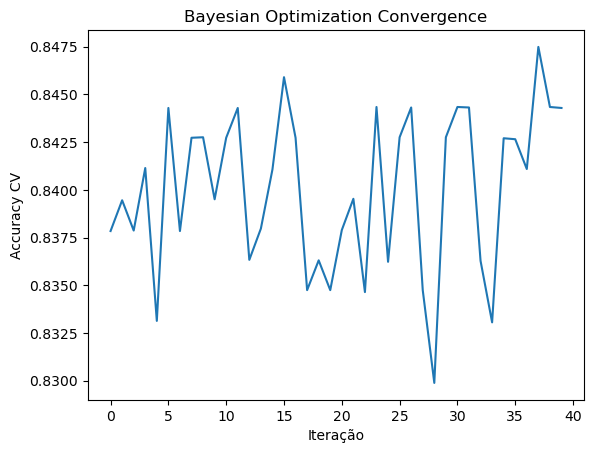

In [17]:
import matplotlib.pyplot as plt

results = bayes_search.cv_results_

plt.figure()
plt.plot(results['mean_test_score'])
plt.xlabel("Iteração")
plt.ylabel("Accuracy CV")
plt.title("Bayesian Optimization Convergence")
plt.show()
